# Multi-Agent Reinforcement Learning for Electricity Markets

In [ ]:
# Setup  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
%matplotlib inline

# Create outputs directory
OUTPUT_DIR = 'outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"✓ Setup complete")
print(f"✓ Output directory: {OUTPUT_DIR}/")

✓ Setup complete
✓ Output directory: outputs/


In [2]:
# Import modules
from electricity_market import (
    MarketConfig, GeneratorConfig, run_simulation,
    plot_learning_curves, plot_policy_analysis, create_summary_report
)
from market_scenarios import (
    create_market_scenarios, run_comparative_analysis,
    analyze_demand_elasticity, analyze_price_caps
)

print("✓ Imports complete. Ready to run!")

✓ Imports complete. Ready to run!


## 2. Basic Simulation: Symmetric Duopoly

In [3]:
# Configure market and generators
market_config = MarketConfig(demand_intercept=1000.0, demand_slope=-10.0)
generator_configs = [
    GeneratorConfig(id=1, capacity=400, marginal_cost=30),
    GeneratorConfig(id=2, capacity=400, marginal_cost=30)
]

# Run simulation
print("Running simulation (2-3 minutes)...\n")
market, analyzer = run_simulation(market_config, generator_configs, n_episodes=10000, eval_interval=2500)
print("\n✓ Complete!")

Running simulation (2-3 minutes)...

Starting simulation with 2 generators...
Episodes: 10000
------------------------------------------------------------
Episode 2500/10000
  Avg Price: $41.67/MWh
  HHI: 5202
  Lerner Index: 0.280
  Price Volatility: 0.335
  Avg Epsilon: 0.029
------------------------------------------------------------
Episode 5000/10000
  Avg Price: $40.46/MWh
  HHI: 5215
  Lerner Index: 0.259
  Price Volatility: 0.320
  Avg Epsilon: 0.010
------------------------------------------------------------
Episode 7500/10000
  Avg Price: $40.55/MWh
  HHI: 5219
  Lerner Index: 0.260
  Price Volatility: 0.318
  Avg Epsilon: 0.010
------------------------------------------------------------
Episode 10000/10000
  Avg Price: $40.69/MWh
  HHI: 5242
  Lerner Index: 0.263
  Price Volatility: 0.316
  Avg Epsilon: 0.010
------------------------------------------------------------

✓ Complete!


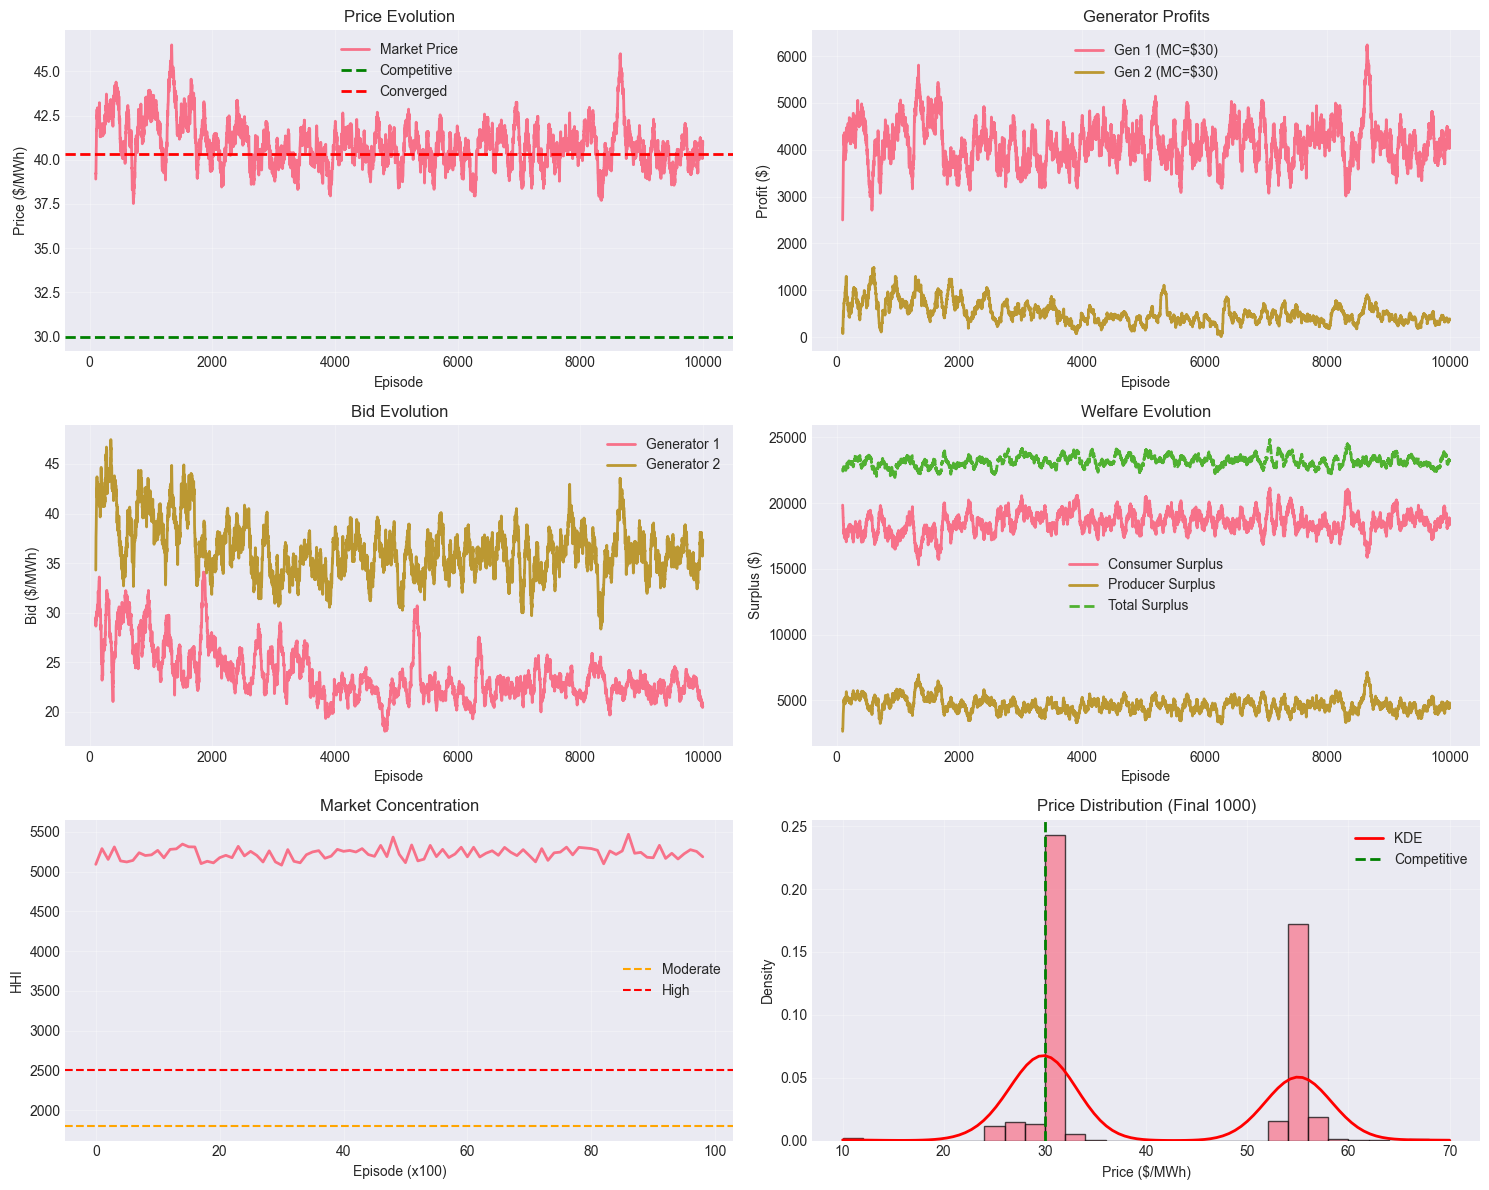

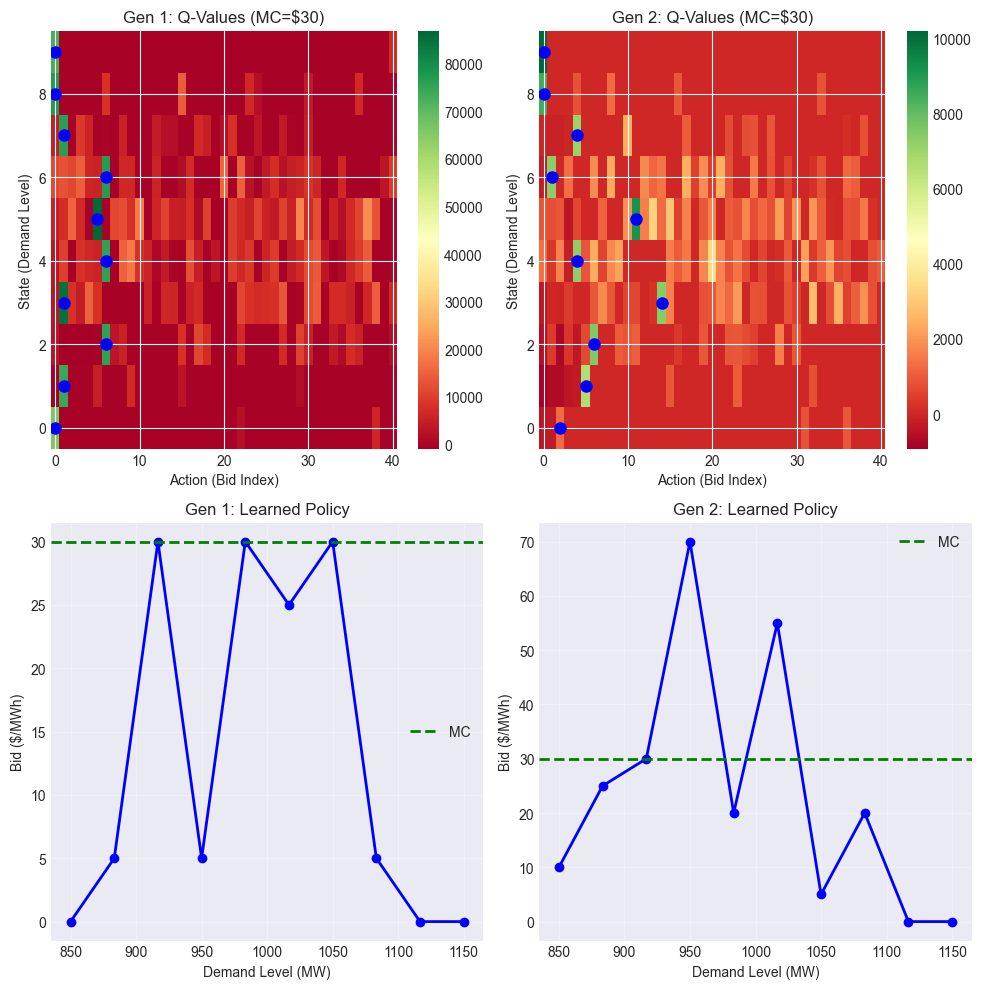


MARKET SUMMARY REPORT

Aggregate Metrics:
                   Metric    Value
        Avg Price ($/MWh)    40.32
Competitive Price ($/MWh)    30.00
         Price Markup (%)    34.4%
        Avg Quantity (MW)    595.0
                      HHI     5227
             Lerner Index    0.256
        Price-Cost Margin    0.344
     Consumer Surplus ($) 18696.51
     Producer Surplus ($)  4453.41
        Total Surplus ($) 23149.92
         Price Volatility    0.317
                  Is Nash       No
   Max Nash Deviation ($)  1978.83

Generator-Specific Metrics:
 Generator  Capacity (MW)  Marginal Cost ($/MWh) Avg Bid ($/MWh) Avg Output (MW) Capacity Factor (%) Avg Profit ($) Lerner Index
         1            400                     30           22.34           361.0                90.2        4079.93        0.256
         2            400                     30           35.71           234.1                58.5         373.48        0.256

✓ Saved all outputs to outputs/


In [4]:
# Visualize
plot_learning_curves(market, save_path=os.path.join(OUTPUT_DIR, 'duopoly_learning.png'))
plt.show()

plot_policy_analysis(market, save_path=os.path.join(OUTPUT_DIR, 'duopoly_policy.png'))
plt.show()

summary_df, gen_df = create_summary_report(
    market, analyzer, save_path=os.path.join(OUTPUT_DIR, 'duopoly_summary.txt')
)

print(f"\n✓ Saved all outputs to {OUTPUT_DIR}/")

## 3. Market Power Analysis

In [5]:
# Compute metrics
window = 1000
hhi = analyzer.compute_hhi(window)
lerner, gen_lerner = analyzer.compute_lerner_index(window)
nash_test = analyzer.test_nash_equilibrium(n_tests=100)

print(f"HHI: {hhi:.0f}")
print(f"Lerner Index: {lerner:.3f}")
print(f"Nash Equilibrium: {nash_test['is_nash']}")
print(f"Max Deviation: ${nash_test['max_deviation']:.2f}")

HHI: 5227
Lerner Index: 0.256
Nash Equilibrium: False
Max Deviation: $1803.30


## 4. Compare Market Structures

In [6]:
# Run comparative analysis
scenarios = create_market_scenarios()
selected = {'sym_duopoly': scenarios['sym_duopoly'], 'sym_triopoly': scenarios['sym_triopoly']}

print("Running comparative analysis (10-15 min)...\n")
comp_results = run_comparative_analysis(selected, n_episodes=8000, n_runs=2)

# Save
comp_results.to_csv(os.path.join(OUTPUT_DIR, 'comparative_results.csv'), index=False)
comp_results.to_latex(os.path.join(OUTPUT_DIR, 'comparative_results.tex'), index=False)

print(f"\n✓ Saved to {OUTPUT_DIR}/")

Running comparative analysis (10-15 min)...

COMPARATIVE ANALYSIS ACROSS MARKET STRUCTURES

Scenario: Symmetric Duopoly
Description: Two identical generators
Generators: 2

  Run 1/2...
Starting simulation with 2 generators...
Episodes: 8000
------------------------------------------------------------
Episode 4000/8000
  Avg Price: $42.25/MWh
  HHI: 5020
  Lerner Index: 0.290
  Price Volatility: 0.342
  Avg Epsilon: 0.014
------------------------------------------------------------
Episode 8000/8000
  Avg Price: $41.99/MWh
  HHI: 5024
  Lerner Index: 0.286
  Price Volatility: 0.323
  Avg Epsilon: 0.010
------------------------------------------------------------

  Run 2/2...
Starting simulation with 2 generators...
Episodes: 8000
------------------------------------------------------------
Episode 4000/8000
  Avg Price: $47.55/MWh
  HHI: 6107
  Lerner Index: 0.369
  Price Volatility: 0.212
  Avg Epsilon: 0.014
------------------------------------------------------------
Episode 8000/8

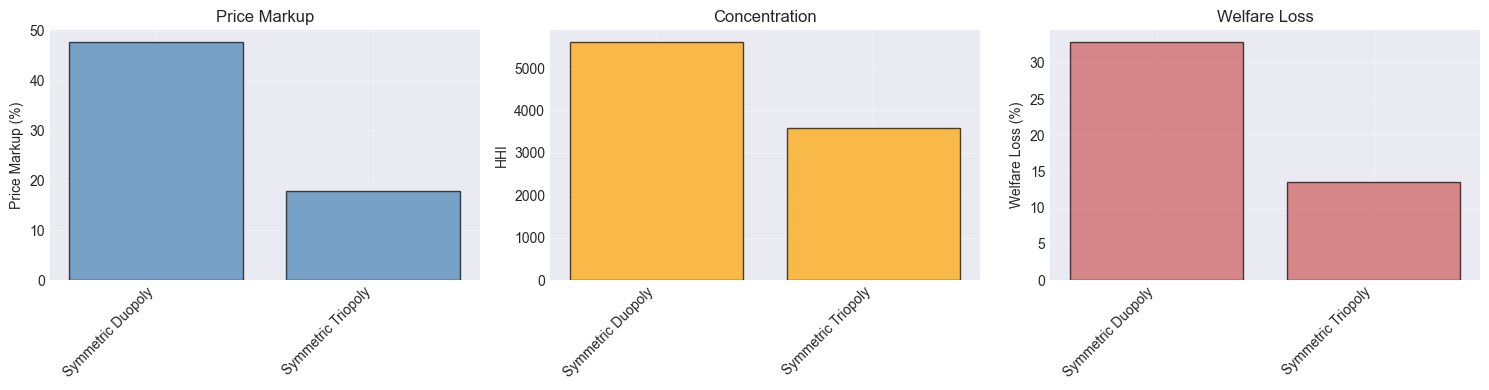

✓ Saved figure


In [7]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.bar(range(len(comp_results)), comp_results['price_markup_pct'], color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(comp_results)))
ax.set_xticklabels(comp_results['scenario'], rotation=45, ha='right')
ax.set_ylabel('Price Markup (%)')
ax.set_title('Price Markup')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.bar(range(len(comp_results)), comp_results['hhi'], color='orange', alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(comp_results)))
ax.set_xticklabels(comp_results['scenario'], rotation=45, ha='right')
ax.set_ylabel('HHI')
ax.set_title('Concentration')
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.bar(range(len(comp_results)), comp_results['welfare_loss_pct'], color='indianred', alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(comp_results)))
ax.set_xticklabels(comp_results['scenario'], rotation=45, ha='right')
ax.set_ylabel('Welfare Loss (%)')
ax.set_title('Welfare Loss')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'comparative_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved figure")

## 5. Sensitivity Analysis

Elasticity analysis (5-10 min)...


Analyzing demand elasticity sensitivity for Symmetric Duopoly...

  Testing elasticity = -5.0
Starting simulation with 2 generators...
Episodes: 6000
------------------------------------------------------------
Episode 6000/6000
  Avg Price: $57.55/MWh
  HHI: 5055
  Lerner Index: 0.479
  Price Volatility: 0.411
  Avg Epsilon: 0.010
------------------------------------------------------------
Starting simulation with 2 generators...
Episodes: 6000
------------------------------------------------------------
Episode 6000/6000
  Avg Price: $64.34/MWh
  HHI: 5127
  Lerner Index: 0.534
  Price Volatility: 0.462
  Avg Epsilon: 0.010
------------------------------------------------------------

  Testing elasticity = -10.0
Starting simulation with 2 generators...
Episodes: 6000
------------------------------------------------------------
Episode 6000/6000
  Avg Price: $54.87/MWh
  HHI: 5038
  Lerner Index: 0.453
  Price Volatility: 0.197
  Avg Epsilon: 0.01

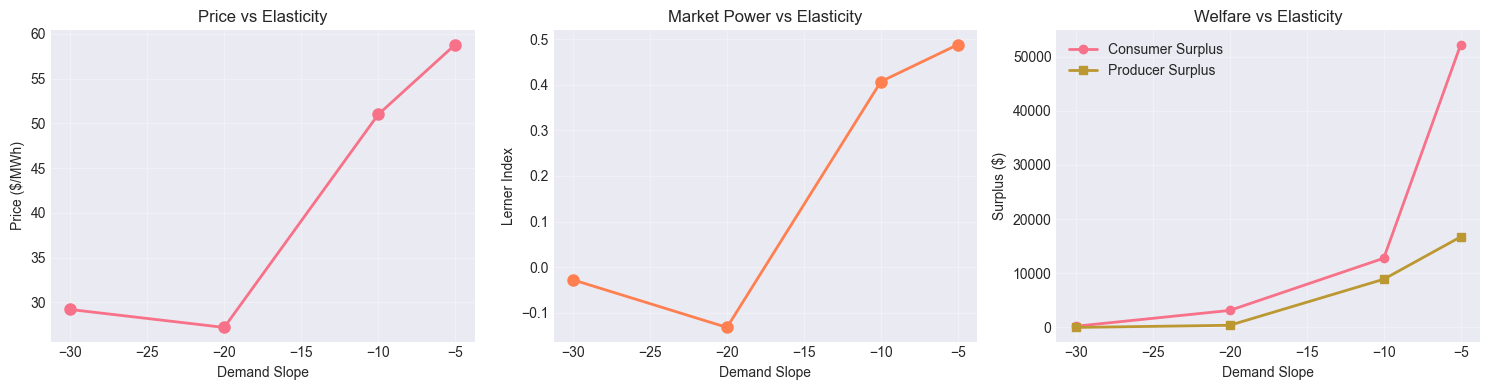


✓ Saved to outputs/


In [8]:
# Demand elasticity
print("Elasticity analysis (5-10 min)...\n")
elasticity_results = analyze_demand_elasticity(
    'sym_duopoly', elasticities=[-5.0, -10.0, -20.0, -30.0], n_episodes=6000, n_runs=2
)

# Save
elasticity_results.to_csv(os.path.join(OUTPUT_DIR, 'elasticity_sensitivity.csv'), index=False)
elasticity_results.to_latex(os.path.join(OUTPUT_DIR, 'elasticity_sensitivity.tex'), index=False)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.plot(elasticity_results['elasticity'], elasticity_results['price'], 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Demand Slope')
ax.set_ylabel('Price ($/MWh)')
ax.set_title('Price vs Elasticity')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(elasticity_results['elasticity'], elasticity_results['lerner'], 'o-', linewidth=2, markersize=8, color='coral')
ax.set_xlabel('Demand Slope')
ax.set_ylabel('Lerner Index')
ax.set_title('Market Power vs Elasticity')
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.plot(elasticity_results['elasticity'], elasticity_results['cs'], 'o-', label='Consumer Surplus', linewidth=2)
ax.plot(elasticity_results['elasticity'], elasticity_results['ps'], 's-', label='Producer Surplus', linewidth=2)
ax.set_xlabel('Demand Slope')
ax.set_ylabel('Surplus ($)')
ax.set_title('Welfare vs Elasticity')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'elasticity_sensitivity.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved to {OUTPUT_DIR}/")

Price cap analysis (5-10 min)...


Analyzing price cap sensitivity for Symmetric Duopoly...

  Testing price cap = $60.0
Starting simulation with 2 generators...
Episodes: 6000
------------------------------------------------------------
Episode 6000/6000
  Avg Price: $40.45/MWh
  HHI: 5236
  Lerner Index: 0.258
  Price Volatility: 0.274
  Avg Epsilon: 0.010
------------------------------------------------------------
Starting simulation with 2 generators...
Episodes: 6000
------------------------------------------------------------
Episode 6000/6000
  Avg Price: $44.86/MWh
  HHI: 5001
  Lerner Index: 0.331
  Price Volatility: 0.317
  Avg Epsilon: 0.010
------------------------------------------------------------

  Testing price cap = $100.0
Starting simulation with 2 generators...
Episodes: 6000
------------------------------------------------------------
Episode 6000/6000
  Avg Price: $51.85/MWh
  HHI: 7162
  Lerner Index: 0.421
  Price Volatility: 0.243
  Avg Epsilon: 0.010
-------

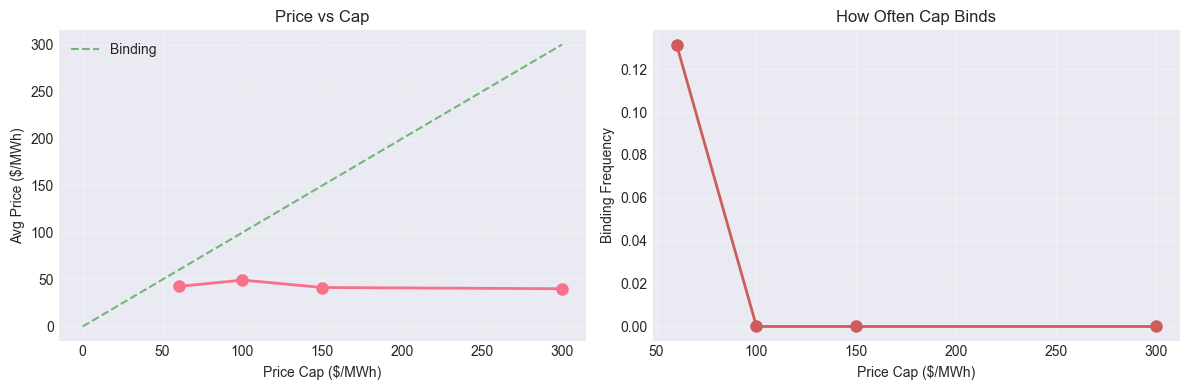


✓ Saved to outputs/


In [9]:
# Price caps
print("Price cap analysis (5-10 min)...\n")
price_cap_results = analyze_price_caps(
    'sym_duopoly', price_caps=[60.0, 100.0, 150.0, 300.0], n_episodes=6000, n_runs=2
)

# Save
price_cap_results.to_csv(os.path.join(OUTPUT_DIR, 'price_cap_sensitivity.csv'), index=False)
price_cap_results.to_latex(os.path.join(OUTPUT_DIR, 'price_cap_sensitivity.tex'), index=False)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.plot(price_cap_results['price_cap'], price_cap_results['price'], 'o-', linewidth=2, markersize=8)
ax.plot([0, 300], [0, 300], 'g--', alpha=0.5, label='Binding')
ax.set_xlabel('Price Cap ($/MWh)')
ax.set_ylabel('Avg Price ($/MWh)')
ax.set_title('Price vs Cap')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(price_cap_results['price_cap'], price_cap_results['cap_binding'], 'o-', linewidth=2, markersize=8, color='indianred')
ax.set_xlabel('Price Cap ($/MWh)')
ax.set_ylabel('Binding Frequency')
ax.set_title('How Often Cap Binds')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'price_cap_sensitivity.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved to {OUTPUT_DIR}/")

## 6. Export Everything for Paper

In [ ]:
# Export all tables to LaTeX 

summary_df.to_latex(os.path.join(OUTPUT_DIR, 'table_summary.tex'), index=False)
gen_df.to_latex(os.path.join(OUTPUT_DIR, 'table_generators.tex'), index=False)

print("✓ Exported all tables to LaTeX")

# List all files
print(f"\n📁 All files in {OUTPUT_DIR}/:")
for f in sorted(os.listdir(OUTPUT_DIR)):
    if not f.startswith('.'):
        size = os.path.getsize(os.path.join(OUTPUT_DIR, f)) / 1024
        print(f"  - {f} ({size:.1f} KB)")

✓ Exported all tables to LaTeX

📁 All files in outputs/:
  - comparative_analysis.png (133.0 KB)
  - comparative_results.csv (0.8 KB)
  - comparative_results.tex (0.8 KB)
  - duopoly_learning.png (1017.0 KB)
  - duopoly_policy.png (324.3 KB)
  - duopoly_summary.txt (1.1 KB)
  - elasticity_sensitivity.csv (0.3 KB)
  - elasticity_sensitivity.png (228.4 KB)
  - elasticity_sensitivity.tex (0.4 KB)
  - price_cap_sensitivity.csv (0.4 KB)
  - price_cap_sensitivity.png (159.1 KB)
  - price_cap_sensitivity.tex (0.4 KB)
  - table_generators.tex (0.3 KB)
  - table_summary.tex (0.4 KB)
